# Ecuación de Calor 1D - Método de Diferencias Finitas (FTCS)

Este notebook resuelve la ecuación de calor 1D:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

usando el esquema explícito **FTCS** (Forward Time, Central Space).

**Resumen del procedimiento:**

1. **Discretización de la malla**: Se divide el dominio espacial en `Nx` puntos y el tiempo en pasos de tamaño `dt`.
2. **Condiciones iniciales**: Usamos una función seno para poder comparar con la solución analítica.
3. **Condiciones de contorno**: Dirichlet homogéneas (`u=0` en los extremos).
4. **Esquema FTCS**: 
   $$
   u_i^{n+1} = u_i^n + r \left( u_{i+1}^n - 2 u_i^n + u_{i-1}^n \right),
   $$
   donde $r = \frac{\alpha \, \Delta t}{(\Delta x)^2}$.
5. **Condición de estabilidad**: $r \leq 0.5$ para estabilidad.
6. **Comparación con la solución analítica**: 
   $$
   u(x,t) = \sin(\pi x/L) \cdot e^{-\alpha (\pi/L)^2 t}
   $$

---


------------------------------------------------
Resumen de la simulación (FTCS calor 1D)
Nx = 51, dx = 0.020000
Nt = 28, dt = 1.785714e-02
r  = α dt / dx^2 = 0.446429  (debe ser ≤ 0.5 para estabilidad)
Errores L2 relativos en tiempos guardados:
  t =  0.00000  ->  ||u_num - u_ex||_2 / ||u_ex||_2 = 2.449e-17
  t =  0.12500  ->  ||u_num - u_ex||_2 / ||u_ex||_2 = 6.819e-06
  t =  0.25000  ->  ||u_num - u_ex||_2 / ||u_ex||_2 = 1.364e-05
  t =  0.50000  ->  ||u_num - u_ex||_2 / ||u_ex||_2 = 2.728e-05
------------------------------------------------


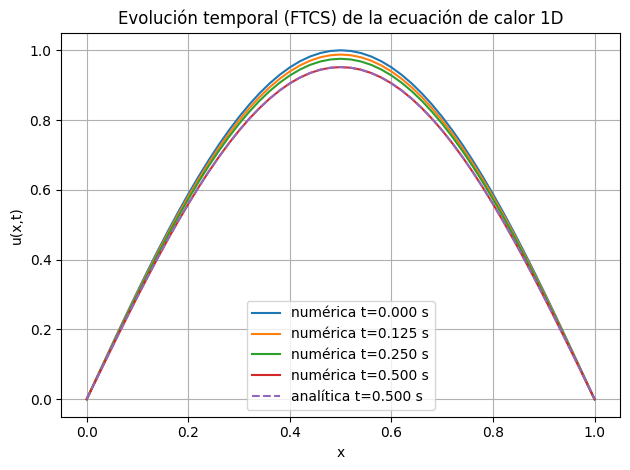

In [7]:
# ===============================================================
#  Ecuación de calor 1D (u_t = α u_xx) con condiciones Dirichlet
#  Esquema explícito FTCS (Forward-Time, Centered-Space)
#
#  - PDE:    ∂u/∂t = α ∂²u/∂x²,   0 < x < L, t > 0
#  - BCs:    u(0,t) = 0,  u(L,t) = 0
#  - IC:     u(x,0) = sin(π x / L)
#
#  Esquema FTCS en malla uniforme:
#     u_i^{n+1} = u_i^n + r ( u_{i+1}^n - 2 u_i^n + u_{i-1}^n ),   1 ≤ i ≤ Nx-2
#  con r = α Δt / Δx².
#
#  Estabilidad (FTCS para calor 1D):     0 < r ≤ 1/2
#  Elegimos r_target < 0.5 y luego ajustamos Δt para que el tiempo final
#  se alcance exactamente (recalculando Nt y Δt).
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Parámetros físicos y numéricos
# -----------------------------
L      = 1.0       # Longitud del dominio [0, L]
alpha  = 0.01      # Difusividad térmica (constante) [L^2 / T]
Nx     = 51        # Número de nodos espaciales (incluye extremos 0 y L)

# Malla espacial uniforme
dx = L / (Nx - 1)
x  = np.linspace(0, L, Nx)

# Tiempo de simulación
t_final   = 0.5    # tiempo final de integración

# Elegimos un r objetivo para cumplir estabilidad (FTCS requiere r ≤ 0.5)
r_target  = 0.45   # Margen de seguridad por debajo de 0.5

# Con r_target fijado, calculamos un Δt provisional
dt = r_target * dx**2 / alpha

# Ajuste para que lleguemos exactamente a t_final:
# - Calculamos el número de pasos enteros Nt
# - Recalculamos dt = t_final / Nt para "cerrar" exactamente en t_final
Nt = int(np.ceil(t_final / dt))     # redondeo hacia arriba para no pasar de t_final
dt = t_final / Nt                   # reajuste fino del paso temporal

# Recalculamos r con el dt definitivo (importante para comprobar estabilidad real)
r = alpha * dt / dx**2

# Comprobación de estabilidad: si r > 0.5, el esquema puede ser inestable
if r > 0.5:
    raise ValueError(
        f"Esquema potencialmente inestable: r = {r:.5f} > 0.5. "
        "Aumenta Nx (reduce dx) o reduce t_final o r_target."
    )

# -----------------------------
# Condición inicial y de contorno
# -----------------------------
# IC suave que es autofunción del operador Laplaciano con BCs homogéneas:
#   u(x,0) = sin(π x / L)
u = np.sin(np.pi * x / L).astype(float)

# BCs de Dirichlet homogéneas (u=0 en los extremos) impuestas en cada paso
u[0]  = 0.0
u[-1] = 0.0

# Vector auxiliar para el "nuevo" estado temporal (evitamos realocar en el bucle)
u_new = u.copy()

# ---------------------------------------
# Tiempos en los que queremos guardar u(x)
# ---------------------------------------
tiempos_guardar = [0.0, 0.25 * t_final, 0.5 * t_final, t_final]

# Convertimos esos tiempos a índices de paso n mediante redondeo;
# además, los "acotamos" a [0, Nt] por seguridad ante redondeos.
indices_guardar = []
for tg in tiempos_guardar:
    n_idx = int(round(tg / dt))
    n_idx = max(0, min(Nt, n_idx))
    indices_guardar.append(n_idx)

# Diccionario para almacenar copias de la solución en los tiempos seleccionados
soluciones_guardadas = {t: None for t in tiempos_guardar}

# ---------------------------------------
# Función: solución analítica para este IC
# ---------------------------------------
def u_analitica(x, t, alpha=alpha, L=L):
    """
    Para IC = sin(π x / L) y BCs homogéneas, la solución exacta es
        u(x,t) = sin(π x / L) * exp( -α (π/L)^2 t ).
    """
    k = np.pi / L
    return np.sin(k * x) * np.exp(-alpha * k**2 * t)

# ---------------------------------------
# Bucle temporal (esquema FTCS explícito)
# ---------------------------------------
# Recorremos n = 0,1,...,Nt. En n=0 guardamos IC si corresponde.
for n in range(Nt + 1):

    # Si este paso n coincide con alguno de los tiempos de interés, guardamos copia
    if n in indices_guardar:
        # Recuperamos el tiempo "nominal" asociado a ese índice para usarlo como clave
        # (si hay empates por redondeo, .index toma la primera coincidencia)
        t_key = tiempos_guardar[indices_guardar.index(n)]
        soluciones_guardadas[t_key] = u.copy()

    # Si ya estamos en el último paso (n == Nt), hemos terminado
    if n == Nt:
        break

    # Actualización FTCS SOLO en nodos interiores (1 ... Nx-2).
    # Las BCs en 0 y Nx-1 permanecen en 0 (Dirichlet homogéneas).
    # Fórmula vectorizada: u_new[1:-1] = u[1:-1] + r*(u[2:] - 2u[1:-1] + u[:-2])
    u_new[1:-1] = u[1:-1] + r * (u[2:] - 2.0 * u[1:-1] + u[:-2])

    # Intercambiamos referencias para el siguiente paso (evitamos copias extra)
    u, u_new = u_new, u

# --------------------------------------------------
# Diagnóstico: errores L2 frente a la solución exacta
# --------------------------------------------------
# Calculamos el error L2 relativo en los tiempos guardados como medida de calidad.
def error_L2_rel(u_num, u_ex):
    num = np.linalg.norm(u_num - u_ex, ord=2)
    den = np.linalg.norm(u_ex,     ord=2)
    return num / den if den > 0 else np.nan

print("------------------------------------------------")
print("Resumen de la simulación (FTCS calor 1D)")
print(f"Nx = {Nx}, dx = {dx:.6f}")
print(f"Nt = {Nt}, dt = {dt:.6e}")
print(f"r  = α dt / dx^2 = {r:.6f}  (debe ser ≤ 0.5 para estabilidad)")
print("Errores L2 relativos en tiempos guardados:")
for t in tiempos_guardar:
    u_ex = u_analitica(x, t)
    u_st = soluciones_guardadas[t]
    eL2  = error_L2_rel(u_st, u_ex)
    print(f"  t = {t:8.5f}  ->  ||u_num - u_ex||_2 / ||u_ex||_2 = {eL2:.3e}")
print("------------------------------------------------")

# -------------
# Visualización
# -------------
# Graficamos las soluciones numéricas en los tiempos guardados y,
# para referencia, la solución analítica en el tiempo final.
for t in tiempos_guardar:
    plt.plot(x, soluciones_guardadas[t], label=f'numérica t={t:.3f} s')

# Solución analítica al tiempo final (línea discontinua)
plt.plot(x, u_analitica(x, t_final), linestyle='--', label=f'analítica t={t_final:.3f} s')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Evolución temporal (FTCS) de la ecuación de calor 1D')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Notas:
# - Si quieres mayor precisión, puedes:
#   (i) aumentar Nx (malla más fina),
#   (ii) elegir un r_target más pequeño (dt menor),
#   (iii) o usar un esquema implícito (p.ej. Crank–Nicolson) que permite dt más grandes.
# - Con esta IC particular (seno), la solución exacta conserva la forma senoidal y
#   simplemente decae exponencialmente en el tiempo con tasa α (π/L)^2.
# --------------------------------------------------
